In [2]:
%load_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import xarray as xr

import os,sys,glob
import re

## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'EUREC4A_rad_profiles'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])


inputdir = os.path.join(repodir,'input/HALO/20200124/AVAPS_Dropsondes/processed/',)
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')

## Graphical parameters
# plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


repo: /Users/bfildier/Code/analyses/EUREC4A/EUREC4A_rad_profiles
Own modules available: []


In [4]:
inputfiles = glob.glob(os.path.join(inputdir,'D*_PQC.nc'))
inputfiles.sort()

In [5]:
data = []

for file in inputfiles :
    data.append(xr.open_dataset(file).dropna(dim='time',subset=['time']).\
                swap_dims({'time':'pres'}).reset_coords().\
                dropna(dim='pres',subset=['alt','pres','u_wind','v_wind','lat','lon','mr'],how='any'))

Nsondes = len(data)

In [51]:
print("extract time information for solar zenith angle calculation")

import datetime
import pytz
from pysolar.solar import *
print(data[0].time.values[0])
date = datetime.datetime.strptime(str(data[0].time.values[0]).split('.')[0],'%Y-%m-%dT%H:%M:%S')
timezone = pytz.timezone("UTC")
date = timezone.localize(date)
print(date)
print(date.tzinfo)

lon = data[0].lon[0].values
lat = data[0].lat[0].values

alt_sol = get_altitude(lat,lon, date)
azim = np.sin(theta_sol*np.pi/180)
print(azim)

extract time information for solar zenith angle calculation
2020-01-24T10:03:09.500000000
2020-01-24 10:03:09+00:00
UTC
-4.974205972886262
0.9474368578953785


In [12]:
data[0].pres.values

array([1011.2242 , 1010.6516 , 1009.52716, ...,  306.97787,  306.59796,
        306.21866], dtype=float32)

In [32]:
# Get min and max
pres_min = np.floor(np.min([data[i].pres.min() for i in range(Nsondes)]))
pres_max = np.ceil(np.max([data[i].pres.max() for i in range(Nsondes)]))

print('min,max = ',pres_min, pres_max)

min,max =  303.0 1015.0


In [ ]:
# interpolate on same grid
data_interp = []

for i in range(Nsondes) :
    data_interp.append(data[i].interp(pres=np.arange(pres_min,pres_max,1)))

In [28]:
combined = xr.concat(data_interp[:],dim='sonde_no')

AttributeError: 'list' object has no attribute 'revert'

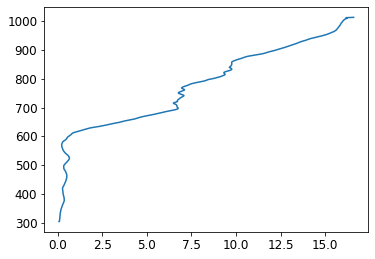

In [46]:
ax = plt.plot(combined.mr.mean(dim='sonde_no'),combined.pres)
ax.revert('y')

# Debug rad.nc file

In [16]:
data[0]

<xarray.Dataset>
Dimensions:         (obs: 1, pres: 1336)
Coordinates:
  * pres            (pres) float32 1011.2242 1010.6516 ... 306.59796 306.21866
Dimensions without coordinates: obs
Data variables:
    trajectory      |S1 b''
    launch_time     datetime64[ns] 2020-01-24T09:50:07
    time            (pres) datetime64[ns] 2020-01-24T10:03:09.500000 ... 2020-01-24T09:50:49
    tdry            (pres) float32 25.768162 25.717064 ... -30.7321 -30.812067
    dp              (pres) float32 20.972649 20.949871 ... -52.830357 -52.754093
    rh              (pres) float32 74.41568 74.540215 ... 10.629817 10.8
    u_wind          (pres) float32 -5.0939436 -4.957089 ... 21.11877 21.103004
    v_wind          (pres) float32 2.8880584 2.6535368 ... -13.171514 -13.223507
    w_wind          (pres) float32 -0.18463948 -0.1916296 ... -1.4158301
    wspd            (pres) float32 5.855693 5.622632 ... 24.88958 24.903774
    wdir            (pres) float32 119.5515 118.16023 ... 301.95114 302.07184
  

In [14]:
data_before_rad = xr.open_dataset('D20200119_161410_PQC_rad.nc')

In [19]:
data_before_rad.rename({'p_lay':'play'},inplace=True)
data_before_rad

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  """Entry point for launching an IPython kernel.


ValueError: cannot rename 'p_lay' because it is not a variable or dimension in this dataset